In [5]:
import torch
import torch.utils
import torch.utils.data
from tqdm.auto import tqdm
from torch import nn
import argparse
import torch.nn.functional as F
import utils
import dataset
import os
import matplotlib.pyplot as plt

In [6]:
import numpy as np

dataPath = 'data/albatross.npy'
data = np.load(dataPath)
print(data.shape)

(32561, 16, 4)


In [7]:
dataPath2 = 'data/albatross_prior_samples.npy'
data2 = np.load(dataPath2)
print(data2.shape)

(32561, 64)


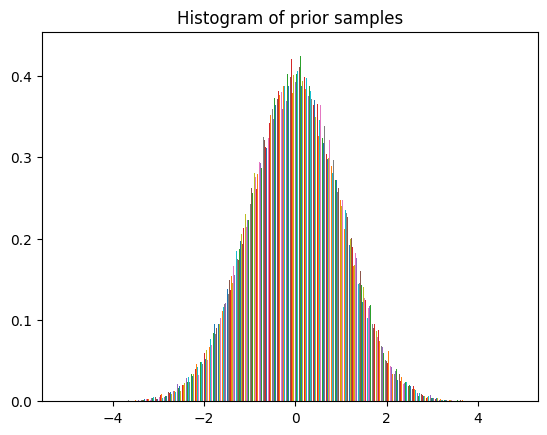

In [8]:
# Make a histogram of the prior sample data
plt.hist(data2, bins=100, density=True)
plt.title('Histogram of prior samples')
plt.show()

In [9]:
moonDataX, moonDataY = dataset.load_dataset('moons')
print(type(moonDataX))
print(moonDataX.shape)
print(type(moonDataY))
print(moonDataY.shape)

<class 'torch.Tensor'>
torch.Size([8000, 2])
<class 'torch.Tensor'>
torch.Size([8000])


In [10]:
# Define the time embedding class to generate sinusoidal embeddings
class TimeEmbedding(nn.Module):
    def __init__(self, numDim : int):
        super().__init__()
        self.numDim = numDim

    def forward(self, time : torch.Tensor):
        '''
        Input:
            time: (batchSize, 1)
        Output:
            embedding: (batchSize, numDim)
        '''
        # Generate the sinusoidal embeddings
        embedding = torch.zeros(time.shape[0], self.numDim)
        for i in range(self.numDim):
            if i % 2 == 0:
                embedding[:, i] = torch.sin(time / 10000 ** (i / self.numDim))
            else:
                embedding[:, i] = torch.cos(time / 10000 ** ((i - 1) / self.numDim))
        return embedding


In [11]:
# Test the time embedding class to generate sinusoidal embeddings
timeEmbedding = TimeEmbedding(10)
timeSteps = torch.arange(0, 100)
print(timeSteps.shape)
embeddings = timeEmbedding(timeSteps)
print(embeddings.shape)
print(embeddings[2, :])

torch.Size([100])
torch.Size([100, 10])
tensor([ 0.9093, -0.4161,  0.3117,  0.9502,  0.0502,  0.9987,  0.0080,  1.0000,
         0.0013,  1.0000])


In [12]:
# Write the Noise Scheduler class that will be used for training the DDPM Model
class NoiseScheduler():
    """
    Noise scheduler for the DDPM model

    Args:
        num_timesteps: int, the number of timesteps
        type: str, the type of scheduler to use
        **kwargs: additional arguments for the scheduler

    This object sets up all the constants like alpha, beta, sigma, etc. required for the DDPM model
    
    """
    def __init__(self, num_timesteps=50, type="linear", **kwargs):

        self.num_timesteps = num_timesteps
        self.type = type

        if type == "linear":
            self.init_linear_schedule(**kwargs)
        else:
            raise NotImplementedError(f"{type} scheduler is not implemented") # change this if you implement additional schedulers


    def init_linear_schedule(self, beta_start, beta_end):
        """
        Precompute whatever quantities are required for training and sampling
        """
        self.betaSchedule = torch.linspace(beta_start, beta_end, self.num_timesteps)
        self.alpha = 1 - self.betaSchedule
        self.alphaProd = torch.cumprod(self.alpha, 0)
        self.sqrtCumprodAlpha = np.sqrt(self.alphaProd)
        self.sqrtAlpha = np.sqrt(self.alpha)
        self.sqrtOneMinusAlpha = np.sqrt(1 - self.alpha)
        self.sqrtOneMinusAlphaProd = torch.sqrt(1 - self.alphaProd)

    def __len__(self):
        return self.num_timesteps

In [13]:
noiseScheduler = NoiseScheduler(num_timesteps=50, 
                                type="linear", 
                                beta_start=0.0001, 
                                beta_end=0.02)
# print(noiseScheduler.betaSchedule)
print(noiseScheduler.alpha)

tensor([0.9999, 0.9995, 0.9991, 0.9987, 0.9983, 0.9979, 0.9975, 0.9971, 0.9967,
        0.9962, 0.9958, 0.9954, 0.9950, 0.9946, 0.9942, 0.9938, 0.9934, 0.9930,
        0.9926, 0.9922, 0.9918, 0.9914, 0.9910, 0.9906, 0.9902, 0.9897, 0.9893,
        0.9889, 0.9885, 0.9881, 0.9877, 0.9873, 0.9869, 0.9865, 0.9861, 0.9857,
        0.9853, 0.9849, 0.9845, 0.9841, 0.9837, 0.9832, 0.9828, 0.9824, 0.9820,
        0.9816, 0.9812, 0.9808, 0.9804, 0.9800])


In [14]:
class MLPModel(nn.Module):
    def __init__(self, inputDim : int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output


In [15]:
class AdvancedMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        # Keep the rest of the model same, change the activation function to SiLU
        self.fc1 = nn.Linear(inputDim + timeEmbedDim, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.SiLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

        

In [16]:
class ResidualMLPModel(nn.Module):
    def __init__(self, inputDim: int, timeEmbedDim: int, hiddenDim: int = 256):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim

        # Input projection layer
        self.input_proj = nn.Linear(inputDim + timeEmbedDim, hiddenDim)

        # Main network with residual blocks
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hiddenDim, hiddenDim),  # Concatenate time embedding
                nn.SiLU(),
                nn.Linear(hiddenDim, hiddenDim)
            )
            for _ in range(4)  # Number of residual blocks
        ])

        # Output projection layer
        self.output_proj = nn.Linear(hiddenDim, inputDim)

    def forward(self, x):
        """
        Forward pass of the model.
        Args:
            x: Input tensor of shape (batch_size, inputDim)
            time: Time tensor of shape (batch_size, 1)
        Returns:
            Output tensor of shape (batch_size, inputDim)
        """
        # Time embedding
        # time_embed = self.time_embed(time)  # (batch_size, timeEmbedDim)

        # Input projection
        h = self.input_proj(x)  # (batch_size, hiddenDim)

        # Residual blocks
        for block in self.residual_blocks:
            # Concatenate time embedding
            # h_input = torch.cat([h, time_embed], dim=-1)  # (batch_size, hiddenDim + timeEmbedDim)
            # Residual connection
            h = h + block(h)  # (batch_size, hiddenDim)

        # Output projection
        out = self.output_proj(h)  # (batch_size, inputDim)

        return out

In [17]:
class DDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200):
        """
        Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
        We have separate learnable modules for `time_embed` and `model`. `time_embed` can be learned or a fixed function as well

        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        # self.model = MLPModel(n_dim, self.time_embed_dim)
        # self.model = AdvancedMLPModel(n_dim, self.time_embed_dim)
        self.model = ResidualMLPModel(n_dim, self.time_embed_dim)

    def forward(self, x, t):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Concatenate the input data with the time embeddings
        input = torch.cat([x, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [18]:
# Define a test model
# ddpm = DDPM(n_dim=3, n_steps=200)
ddpm = DDPM(n_dim=3, n_steps=200)
x = torch.randn(10, 3)
t = torch.randint(0, 200, (10,))
print(x.shape)
print(t.shape)
output = ddpm(x, t)
print(output.shape)

torch.Size([10, 3])
torch.Size([10])
torch.Size([10, 3])


In [19]:
def train(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the model and save the model and necessary plots

    Args:
        model: DDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            # Define the random time step
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

In [20]:
print(moonDataX.shape)

torch.Size([8000, 2])


In [22]:
# Define the dataset and dataloader
batchSize = 64
n_steps = 200
dataset = moonDataX
n_dim = dataset.shape[1]
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the model
ddpm = DDPM(n_dim=n_dim, n_steps=n_steps)
# Define the optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
# Train the model
train(ddpm, noiseScheduler, 
      dataloader, optimizer, epochs=100, 
      run_name="moon_test1")

Epoch 1/100: 100%|██████████| 125/125 [00:00<00:00, 220.06it/s]


Epoch 1/100 Loss: 0.7383969976902008


Epoch 2/100: 100%|██████████| 125/125 [00:00<00:00, 212.55it/s]


Epoch 2/100 Loss: 0.7172368245124817


Epoch 3/100: 100%|██████████| 125/125 [00:00<00:00, 216.28it/s]


Epoch 3/100 Loss: 0.6644241881370544


Epoch 4/100: 100%|██████████| 125/125 [00:00<00:00, 214.47it/s]


Epoch 4/100 Loss: 0.6611680662631989


Epoch 5/100: 100%|██████████| 125/125 [00:00<00:00, 215.07it/s]


Epoch 5/100 Loss: 0.6446918888092041


Epoch 6/100: 100%|██████████| 125/125 [00:00<00:00, 213.19it/s]


Epoch 6/100 Loss: 0.6422219407558442


Epoch 7/100: 100%|██████████| 125/125 [00:00<00:00, 209.36it/s]


Epoch 7/100 Loss: 0.636266797542572


Epoch 8/100: 100%|██████████| 125/125 [00:00<00:00, 209.66it/s]


Epoch 8/100 Loss: 0.6430928695201874


Epoch 9/100: 100%|██████████| 125/125 [00:00<00:00, 209.53it/s]


Epoch 9/100 Loss: 0.6438468961715699


Epoch 10/100: 100%|██████████| 125/125 [00:00<00:00, 213.98it/s]


Epoch 10/100 Loss: 0.6313741362094879


Epoch 11/100: 100%|██████████| 125/125 [00:00<00:00, 216.60it/s]


Epoch 11/100 Loss: 0.6493142766952514


Epoch 12/100: 100%|██████████| 125/125 [00:00<00:00, 198.62it/s]


Epoch 12/100 Loss: 0.6320356688499451


Epoch 13/100: 100%|██████████| 125/125 [00:00<00:00, 188.64it/s]


Epoch 13/100 Loss: 0.6541893980503082


Epoch 14/100: 100%|██████████| 125/125 [00:00<00:00, 199.12it/s]


Epoch 14/100 Loss: 0.6462275743484497


Epoch 15/100: 100%|██████████| 125/125 [00:00<00:00, 212.62it/s]


Epoch 15/100 Loss: 0.6497865841388702


Epoch 16/100: 100%|██████████| 125/125 [00:00<00:00, 214.32it/s]


Epoch 16/100 Loss: 0.6242395870685578


Epoch 17/100: 100%|██████████| 125/125 [00:00<00:00, 207.97it/s]


Epoch 17/100 Loss: 0.6220755660533905


Epoch 18/100: 100%|██████████| 125/125 [00:00<00:00, 213.84it/s]


Epoch 18/100 Loss: 0.6359243142604828


Epoch 19/100: 100%|██████████| 125/125 [00:00<00:00, 205.72it/s]


Epoch 19/100 Loss: 0.644335730791092


Epoch 20/100: 100%|██████████| 125/125 [00:00<00:00, 208.05it/s]


Epoch 20/100 Loss: 0.6256933929920196


Epoch 21/100: 100%|██████████| 125/125 [00:00<00:00, 203.23it/s]


Epoch 21/100 Loss: 0.6334796631336213


Epoch 22/100: 100%|██████████| 125/125 [00:00<00:00, 212.20it/s]


Epoch 22/100 Loss: 0.6329002742767333


Epoch 23/100: 100%|██████████| 125/125 [00:00<00:00, 180.82it/s]


Epoch 23/100 Loss: 0.6385926737785339


Epoch 24/100: 100%|██████████| 125/125 [00:00<00:00, 182.09it/s]


Epoch 24/100 Loss: 0.6249677810668945


Epoch 25/100: 100%|██████████| 125/125 [00:00<00:00, 190.37it/s]


Epoch 25/100 Loss: 0.6312763636112213


Epoch 26/100: 100%|██████████| 125/125 [00:00<00:00, 204.77it/s]


Epoch 26/100 Loss: 0.6285860195159912


Epoch 27/100: 100%|██████████| 125/125 [00:00<00:00, 198.37it/s]


Epoch 27/100 Loss: 0.6212048492431641


Epoch 28/100: 100%|██████████| 125/125 [00:00<00:00, 201.49it/s]


Epoch 28/100 Loss: 0.6536992750167847


Epoch 29/100: 100%|██████████| 125/125 [00:00<00:00, 218.60it/s]


Epoch 29/100 Loss: 0.6287117807865142


Epoch 30/100: 100%|██████████| 125/125 [00:00<00:00, 215.61it/s]


Epoch 30/100 Loss: 0.6373998222351074


Epoch 31/100: 100%|██████████| 125/125 [00:00<00:00, 195.06it/s]


Epoch 31/100 Loss: 0.6302936613559723


Epoch 32/100: 100%|██████████| 125/125 [00:00<00:00, 176.59it/s]


Epoch 32/100 Loss: 0.6185187654495239


Epoch 33/100: 100%|██████████| 125/125 [00:00<00:00, 181.04it/s]


Epoch 33/100 Loss: 0.6436369998455047


Epoch 34/100: 100%|██████████| 125/125 [00:00<00:00, 205.28it/s]


Epoch 34/100 Loss: 0.6265049538612366


Epoch 35/100: 100%|██████████| 125/125 [00:00<00:00, 210.42it/s]


Epoch 35/100 Loss: 0.6267324242591857


Epoch 36/100: 100%|██████████| 125/125 [00:00<00:00, 205.09it/s]


Epoch 36/100 Loss: 0.638075971364975


Epoch 37/100: 100%|██████████| 125/125 [00:00<00:00, 196.98it/s]


Epoch 37/100 Loss: 0.6335790503025055


Epoch 38/100: 100%|██████████| 125/125 [00:00<00:00, 174.24it/s]


Epoch 38/100 Loss: 0.6306155042648316


Epoch 39/100: 100%|██████████| 125/125 [00:00<00:00, 165.55it/s]


Epoch 39/100 Loss: 0.6347408390045166


Epoch 40/100: 100%|██████████| 125/125 [00:00<00:00, 178.11it/s]


Epoch 40/100 Loss: 0.6408065004348755


Epoch 41/100: 100%|██████████| 125/125 [00:00<00:00, 176.19it/s]


Epoch 41/100 Loss: 0.6182636096477508


Epoch 42/100: 100%|██████████| 125/125 [00:00<00:00, 200.43it/s]


Epoch 42/100 Loss: 0.6204682443141937


Epoch 43/100: 100%|██████████| 125/125 [00:00<00:00, 186.95it/s]


Epoch 43/100 Loss: 0.6340008270740509


Epoch 44/100: 100%|██████████| 125/125 [00:00<00:00, 210.19it/s]


Epoch 44/100 Loss: 0.6360845394134521


Epoch 45/100: 100%|██████████| 125/125 [00:00<00:00, 178.44it/s]


Epoch 45/100 Loss: 0.6152213258743287


Epoch 46/100: 100%|██████████| 125/125 [00:00<00:00, 215.87it/s]


Epoch 46/100 Loss: 0.6379986870288848


Epoch 47/100: 100%|██████████| 125/125 [00:00<00:00, 220.16it/s]


Epoch 47/100 Loss: 0.6300342788696289


Epoch 48/100: 100%|██████████| 125/125 [00:00<00:00, 186.66it/s]


Epoch 48/100 Loss: 0.6168652725219727


Epoch 49/100: 100%|██████████| 125/125 [00:00<00:00, 195.79it/s]


Epoch 49/100 Loss: 0.6201745519638061


Epoch 50/100: 100%|██████████| 125/125 [00:00<00:00, 183.48it/s]


Epoch 50/100 Loss: 0.6387101831436157


Epoch 51/100: 100%|██████████| 125/125 [00:00<00:00, 197.84it/s]


Epoch 51/100 Loss: 0.6237603008747101


Epoch 52/100: 100%|██████████| 125/125 [00:00<00:00, 184.18it/s]


Epoch 52/100 Loss: 0.6343915686607361


Epoch 53/100: 100%|██████████| 125/125 [00:00<00:00, 190.94it/s]


Epoch 53/100 Loss: 0.6423917491436004


Epoch 54/100: 100%|██████████| 125/125 [00:00<00:00, 201.91it/s]


Epoch 54/100 Loss: 0.6336427383422851


Epoch 55/100: 100%|██████████| 125/125 [00:00<00:00, 204.23it/s]


Epoch 55/100 Loss: 0.6280490860939026


Epoch 56/100: 100%|██████████| 125/125 [00:00<00:00, 160.78it/s]


Epoch 56/100 Loss: 0.6327496075630188


Epoch 57/100: 100%|██████████| 125/125 [00:00<00:00, 190.60it/s]


Epoch 57/100 Loss: 0.6188770084381103


Epoch 58/100: 100%|██████████| 125/125 [00:00<00:00, 190.47it/s]


Epoch 58/100 Loss: 0.6231980264186859


Epoch 59/100: 100%|██████████| 125/125 [00:00<00:00, 151.68it/s]


Epoch 59/100 Loss: 0.6368460936546325


Epoch 60/100: 100%|██████████| 125/125 [00:00<00:00, 178.81it/s]


Epoch 60/100 Loss: 0.6232988274097443


Epoch 61/100: 100%|██████████| 125/125 [00:00<00:00, 203.93it/s]


Epoch 61/100 Loss: 0.625413907289505


Epoch 62/100: 100%|██████████| 125/125 [00:00<00:00, 196.15it/s]


Epoch 62/100 Loss: 0.6348793632984161


Epoch 63/100: 100%|██████████| 125/125 [00:00<00:00, 188.93it/s]


Epoch 63/100 Loss: 0.6092200005054473


Epoch 64/100: 100%|██████████| 125/125 [00:00<00:00, 205.65it/s]


Epoch 64/100 Loss: 0.6188071730136872


Epoch 65/100: 100%|██████████| 125/125 [00:00<00:00, 203.10it/s]


Epoch 65/100 Loss: 0.6440318253040314


Epoch 66/100: 100%|██████████| 125/125 [00:00<00:00, 199.14it/s]


Epoch 66/100 Loss: 0.6181242372989655


Epoch 67/100: 100%|██████████| 125/125 [00:00<00:00, 196.04it/s]


Epoch 67/100 Loss: 0.6033556361198426


Epoch 68/100: 100%|██████████| 125/125 [00:00<00:00, 198.42it/s]


Epoch 68/100 Loss: 0.6299245324134827


Epoch 69/100: 100%|██████████| 125/125 [00:00<00:00, 196.98it/s]


Epoch 69/100 Loss: 0.6086032814979553


Epoch 70/100: 100%|██████████| 125/125 [00:00<00:00, 207.60it/s]


Epoch 70/100 Loss: 0.6225851988792419


Epoch 71/100: 100%|██████████| 125/125 [00:00<00:00, 204.14it/s]


Epoch 71/100 Loss: 0.6307196130752564


Epoch 72/100: 100%|██████████| 125/125 [00:00<00:00, 199.28it/s]


Epoch 72/100 Loss: 0.6099058122634887


Epoch 73/100: 100%|██████████| 125/125 [00:00<00:00, 181.94it/s]


Epoch 73/100 Loss: 0.6171200280189514


Epoch 74/100: 100%|██████████| 125/125 [00:00<00:00, 196.40it/s]


Epoch 74/100 Loss: 0.617642475605011


Epoch 75/100: 100%|██████████| 125/125 [00:00<00:00, 200.01it/s]


Epoch 75/100 Loss: 0.6106488282680511


Epoch 76/100: 100%|██████████| 125/125 [00:00<00:00, 173.49it/s]


Epoch 76/100 Loss: 0.6245916192531585


Epoch 77/100: 100%|██████████| 125/125 [00:00<00:00, 181.09it/s]


Epoch 77/100 Loss: 0.6157291519641876


Epoch 78/100: 100%|██████████| 125/125 [00:00<00:00, 198.76it/s]


Epoch 78/100 Loss: 0.6285687048435211


Epoch 79/100: 100%|██████████| 125/125 [00:00<00:00, 194.09it/s]


Epoch 79/100 Loss: 0.6223936543464661


Epoch 80/100: 100%|██████████| 125/125 [00:00<00:00, 212.49it/s]


Epoch 80/100 Loss: 0.6253892304897308


Epoch 81/100: 100%|██████████| 125/125 [00:00<00:00, 191.42it/s]


Epoch 81/100 Loss: 0.6326773827075958


Epoch 82/100: 100%|██████████| 125/125 [00:00<00:00, 188.19it/s]


Epoch 82/100 Loss: 0.6318256039619445


Epoch 83/100: 100%|██████████| 125/125 [00:00<00:00, 211.48it/s]


Epoch 83/100 Loss: 0.6155751731395721


Epoch 84/100: 100%|██████████| 125/125 [00:00<00:00, 223.98it/s]


Epoch 84/100 Loss: 0.6364517416954041


Epoch 85/100: 100%|██████████| 125/125 [00:00<00:00, 217.62it/s]


Epoch 85/100 Loss: 0.6272425982952118


Epoch 86/100: 100%|██████████| 125/125 [00:00<00:00, 217.77it/s]


Epoch 86/100 Loss: 0.6180952789783478


Epoch 87/100: 100%|██████████| 125/125 [00:00<00:00, 216.99it/s]


Epoch 87/100 Loss: 0.6200689117908478


Epoch 88/100: 100%|██████████| 125/125 [00:00<00:00, 221.85it/s]


Epoch 88/100 Loss: 0.6202659523487091


Epoch 89/100: 100%|██████████| 125/125 [00:00<00:00, 221.96it/s]


Epoch 89/100 Loss: 0.6208706922531128


Epoch 90/100: 100%|██████████| 125/125 [00:00<00:00, 225.57it/s]


Epoch 90/100 Loss: 0.6243890419006347


Epoch 91/100: 100%|██████████| 125/125 [00:00<00:00, 225.81it/s]


Epoch 91/100 Loss: 0.6169867639541626


Epoch 92/100: 100%|██████████| 125/125 [00:00<00:00, 179.60it/s]


Epoch 92/100 Loss: 0.6351280734539032


Epoch 93/100: 100%|██████████| 125/125 [00:00<00:00, 195.14it/s]


Epoch 93/100 Loss: 0.6254689438343048


Epoch 94/100: 100%|██████████| 125/125 [00:00<00:00, 219.48it/s]


Epoch 94/100 Loss: 0.6131615872383118


Epoch 95/100: 100%|██████████| 125/125 [00:00<00:00, 222.67it/s]


Epoch 95/100 Loss: 0.6261107118129731


Epoch 96/100: 100%|██████████| 125/125 [00:00<00:00, 223.66it/s]


Epoch 96/100 Loss: 0.6159850349426269


Epoch 97/100: 100%|██████████| 125/125 [00:00<00:00, 223.05it/s]


Epoch 97/100 Loss: 0.6281112895011902


Epoch 98/100: 100%|██████████| 125/125 [00:00<00:00, 218.38it/s]


Epoch 98/100 Loss: 0.6120312919616699


Epoch 99/100: 100%|██████████| 125/125 [00:00<00:00, 218.60it/s]


Epoch 99/100 Loss: 0.6233360171318054


Epoch 100/100: 100%|██████████| 125/125 [00:00<00:00, 224.07it/s]

Epoch 100/100 Loss: 0.6295584237575531


In [23]:
@torch.no_grad()
def sample(model, n_samples, noise_scheduler, return_intermediate=False):
    """
    Sample from the model
    
    Args:
        model: DDPM
        n_samples: int
        noise_scheduler: NoiseScheduler
        return_intermediate: bool
    Returns:
        torch.Tensor, samples from the model [n_samples, n_dim]

    If `return_intermediate` is `False`,
            torch.Tensor, samples from the model [n_samples, n_dim]
    Else
        the function returns all the intermediate steps in the diffusion process as well 
        Return: [[n_samples, n_dim]] x n_steps
        Optionally implement return_intermediate=True, will aid in visualizing the intermediate steps
    """  
    device = next(model.parameters()).device
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)

    for timestep in reversed(range(0, noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs

    

In [24]:
# Test the sampling function
trainedModel = DDPM(n_dim=2, n_steps=200)
trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))
# trainedModel.eval()
samples = sample(trainedModel, 8000, noiseScheduler, 
                 return_intermediate=True)
# print(samples.shape)

/tmp/ipykernel_6125/1447921429.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test1.pth'))


In [25]:
print(len(samples))
from utils import animateScatter2d
from IPython.display import HTML

figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animation = animateScatter2d(figure, axes, samples, title="Diffusion Process")
plt.close()
display(HTML(animation.to_html5_video()))

50


In [ ]:
print(samples[0])

[[ 1.3014534  -0.34031615]
 [-0.3987732  -0.3000344 ]
 [-0.45690513 -0.47194234]
 ...
 [-1.7253169  -0.9348629 ]
 [-0.30594704  1.2565833 ]
 [ 0.56599367  0.28898597]]


In [26]:
class ConditionalMLPModel(nn.Module):
    def __init__(self, inputDim : int, numClasses: int, timeEmbedDim : int, hiddenDim : int = 128):
        super().__init__()
        self.inputDim = inputDim
        self.timeEmbedDim = timeEmbedDim
        self.hiddenDim = hiddenDim
        self.numClasses = numClasses
        self.fc1 = nn.Linear(inputDim + timeEmbedDim + numClasses, hiddenDim // 2)
        self.fc2 = nn.Linear(hiddenDim // 2, hiddenDim)
        self.fc3 = nn.Linear(hiddenDim, hiddenDim)
        self.fc4 = nn.Linear(hiddenDim, hiddenDim // 2)
        self.fc5 = nn.Linear(hiddenDim // 2, inputDim)
        self.activation = nn.ReLU()
    
    def forward(self, input : torch.Tensor) -> torch.Tensor:
        '''
        Input:
            input: (batchSize, inputDim)
        Output:
            output: (batchSize, inputDim)
        '''
        output = self.fc1(input)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        output = self.activation(output)
        output = self.fc4(output)
        output = self.activation(output)
        output = self.fc5(output)
        return output

In [27]:
class ConditionalDDPM(nn.Module):
    def __init__(self, n_dim=3, n_steps=200,
                 n_classes=2):
        """
        Conditional Noise prediction network for the DDPM

        Args:
            n_dim: int, the dimensionality of the data
            n_steps: int, the number of steps in the diffusion process
            n_classes: int, the number of classes
        We have separate learnable modules for `time_embed`, `class_embed` and `model`. `time_embed` can be learned or a fixed function as well
        """
        super().__init__()
        self.n_dim = n_dim
        self.n_steps = n_steps
        self.time_embed_dim = n_dim
        self.class_embed_dim = n_classes
        self.time_embed = TimeEmbedding(self.time_embed_dim)
        self.class_embed = nn.Embedding(n_classes, n_dim)
        self.model = ConditionalMLPModel(n_dim, self.time_embed_dim, self.class_embed_dim)
    
    def forward(self, x, t, y):
        """
        Args:
            x: torch.Tensor, the input data tensor [batch_size, n_dim]
            t: torch.Tensor, the timestep tensor [batch_size]
            y: torch.Tensor, the class tensor [batch_size]

        Returns:
            torch.Tensor, the predicted noise tensor [batch_size, n_dim]
        """
        # Get the time embeddings
        timeEmbeddings = self.time_embed(t)
        # Get the class embeddings
        classEmbeddings = self.class_embed(y)
        # Concatenate the input data with the time embeddings and class embeddings
        input = torch.cat([x, classEmbeddings, timeEmbeddings], dim=-1)
        # Get the predicted noise
        noise = self.model(input)
        return noise

In [28]:
def trainConditional(model, noise_scheduler, dataloader, optimizer, epochs, run_name):
    """
    Train the conditional model and save the model and necessary plots

    Args:
        model: ConditionalDDPM, model to train
        noise_scheduler: NoiseScheduler, scheduler for the noise
        dataloader: torch.utils.data.DataLoader, dataloader for the dataset
        optimizer: torch.optim.Optimizer, optimizer to use
        epochs: int, number of epochs to train the model
        run_name: str, path to save the model
    """
    model.train()
    lossFunction = nn.MSELoss()
    device = next(model.parameters()).device
    for epoch in range(epochs):
        epochLoss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            y = y.to(device)
            # Define the random time step
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, 
                                      (x.shape[0],), device=device)
            # Get the noise
            noise = torch.randn_like(x)
            noisyInput = (noise_scheduler.sqrtCumprodAlpha[timesteps, None] * x 
                          + noise_scheduler.sqrtOneMinusAlphaProd[timesteps, None] * noise)
            optimizer.zero_grad()
            predictedNoise = model(noisyInput, timesteps, y)
            loss = lossFunction(predictedNoise, noise)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {epochLoss/len(dataloader)}")
    torch.save(model.state_dict(), f'models/{run_name}.pth')

In [29]:
@torch.no_grad()
def sampleConditional(model, n_samples, noise_scheduler, n_classes, return_intermediate=False):
    """
    Sample from the conditional model
    
    Args:
        model: ConditionalDDPM
        n_samples: int
        noise_scheduler: NoiseScheduler
        n_classes: int
        return_intermediate: bool
    Returns:
        torch.Tensor, samples from the model [n_samples, n_dim]

    If `return_intermediate` is `False`,
            torch.Tensor, samples from the model [n_samples, n_dim]
    Else
        the function returns all the intermediate steps in the diffusion process as well 
        Return: [[n_samples, n_dim]] x n_steps
        Optionally implement return_intermediate=True, will aid in visualizing the intermediate steps
    """  
    device = next(model.parameters()).device
    model.eval()
    samples = [] if return_intermediate else None
    numDim = model.model.inputDim
    inputs = torch.randn(n_samples, numDim, device=device)
    y = torch.randint(0, n_classes, (n_samples,), device=device)

    for timestep in reversed(range(0, noise_scheduler.num_timesteps)):
        timesteps = torch.full((n_samples,), timestep, device=device)
        noisePred = model(inputs, timesteps, y)
        inputs = ((inputs - ((1.0 - noise_scheduler.alpha[timestep]) / noise_scheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                  / noise_scheduler.sqrtAlpha[timestep])
        if return_intermediate:
            samples.append(inputs.clone().cpu().numpy())
    if return_intermediate:
        return samples
    return inputs

In [ ]:
# Define a test model
conditionalDDPM = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
x = moonDataX
t = torch.randint(0, 200, (moonDataX.shape[0],))
y = moonDataY
print(x.shape)
print(t.shape)
print(y.shape)
dataloader = torch.utils.data.DataLoader(list(zip(x, y)), 
                                         batch_size=batchSize, 
                                         shuffle=True)
# Define the optimizer
optimizer = torch.optim.Adam(conditionalDDPM.parameters(), lr=1e-3)
# Train the conditional model
trainConditional(conditionalDDPM, noiseScheduler,
                 dataloader, optimizer, epochs=100,
                 run_name="moon_test_conditional")



In [32]:
# Sample from the conditional model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))
samples = sampleConditional(trainedModel, 8000, noiseScheduler, 2,
                            return_intermediate=True)
# print(samples.shape)
figure, axes = plt.subplots(1, 1, figsize=(10, 10))
animation = animateScatter2d(figure, axes, samples, title="Classification Diffusion Process")
plt.close()
display(HTML(animation.to_html5_video()))

/tmp/ipykernel_6125/3937349742.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


In [33]:
from utils import split_data
# Testing the sampled data for quality
subsample_size = 600
train_emd_list = []
test_emd_list = []
trainX, trainY, testX, testY = split_data(moonDataX, moonDataY, 0.8)
for i in range(5):
    subsample_test_X = utils.sample(testX, size = subsample_size)
    subsample_train_X = utils.sample(trainX, size = subsample_size)
    subsample_samples = utils.sample(samples[-1], size = subsample_size)
    test_emd =  utils.get_emd(subsample_test_X, subsample_samples)
    train_emd = utils.get_emd(subsample_train_X, subsample_samples)
    print(f'{i} EMD w.r.t test split : {test_emd: .3f}')
    print(f'{i} EMD w.r.t train split: {train_emd: .3f}')
    train_emd_list.append(train_emd)
    test_emd_list.append(test_emd)

print(f" ---------------------------------")
print(f"Average EMD w.r.t test split : {np.mean(test_emd_list):.3f} ± {np.std(test_emd_list):.3f}")
print(f"Average EMD w.r.t train split: {np.mean(train_emd_list):.3f} ± {np.std(train_emd_list):.3f}")

0 EMD w.r.t test split :  109.919
0 EMD w.r.t train split:  124.439
1 EMD w.r.t test split :  95.536
1 EMD w.r.t train split:  103.580
2 EMD w.r.t test split :  86.036
2 EMD w.r.t train split:  76.767
3 EMD w.r.t test split :  114.551
3 EMD w.r.t train split:  107.989
4 EMD w.r.t test split :  98.884
4 EMD w.r.t train split:  107.785
 ---------------------------------
Average EMD w.r.t test split : 100.985 ± 10.212
Average EMD w.r.t train split: 104.112 ± 15.425


In [104]:
class ClassifierDDPM():
    """
    ClassifierDDPM implements a classification algorithm using the DDPM model.
    """
    
    def __init__(self, model: ConditionalDDPM, 
                 noise_scheduler: NoiseScheduler,
                 time_embedding: TimeEmbedding):
        self.model = model
        self.noiseScheduler = noise_scheduler
        self.numClasses = model.model.numClasses
        self.embeddings = model.class_embed
        self.timeEmbeddings = time_embedding
        # self.n_samples is not used anymore since we use batch_size from x.shape

    def __call__(self, x):
        return self.predict(x)

    def predict_proba(self, x: torch.Tensor):
        """
        Predict the class probabilities for input x by evaluating the reverse process
        conditioned on all possible classes.

        Args:
            x : (batch_size, inputDim) : Input tensor

        Returns:
            (batch_size, numClasses) : Probability distribution over classes
        """
        batch_size, inputDim = x.shape
        # Initialize a random noisy input (starting point for reverse diffusion)
        xT = torch.randn_like(x)
        logProbs = []

        # Loop over each possible class label
        for label in range(self.numClasses):
            # Initialize the conditioned input with the same noisy sample for this class
            inputs = xT.clone()

            # Reverse diffusion process over timesteps
            for timestep in reversed(range(self.noiseScheduler.num_timesteps)):
                # Create a tensor with the current timestep for all samples in the batch
                timesteps = torch.full((batch_size,), timestep, device=x.device)
                # Create a tensor with the current class label for all samples in the batch
                y = torch.full((batch_size,), label, device=x.device)
                # Predict noise conditioned on the current inputs, timestep, and class label
                noisePred = self.model(inputs, timesteps, y)
                # Update the inputs using the noise scheduler parameters
                inputs = ((inputs - ((1.0 - self.noiseScheduler.alpha[timestep]) / 
                                      self.noiseScheduler.sqrtOneMinusAlphaProd[timestep]) * noisePred)
                          / self.noiseScheduler.sqrtAlpha[timestep])
                
            # Compute a log-probability score using negative MSE between the denoised sample and the original input x
            logProb = -F.mse_loss(inputs, x, reduction='none').sum(dim=-1)
            logProbs.append(logProb)
        
        # Stack the scores and apply softmax to obtain probabilities
        logProbs = torch.stack(logProbs, dim=1)
        return F.softmax(logProbs, dim=1)
                
    def predict(self, x: torch.Tensor):
        """
        Predict the class for input x by evaluating the reverse process conditioned on all possible classes.

        Args:
            x : (batch_size, inputDim) : Input tensor

        Returns:
            (batch_size) : Predicted class indices
        """
        proba = self.predict_proba(x)
        return torch.argmax(proba, dim=1)


In [105]:
# Sample from the conditional model
trainedModel = ConditionalDDPM(n_dim=2, n_steps=200, n_classes=2)
trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


# Assuming trainedModel (a trained ConditionalDDPM) is available

# Define parameters
batch_size = 5  # Batch size for testing

# Use the trained model's components
time_embedding = trainedModel.time_embed
classifier = ClassifierDDPM(trainedModel, noiseScheduler, time_embedding)

/tmp/ipykernel_6125/2255868478.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainedModel.load_state_dict(torch.load('models/moon_test_conditional.pth'))


In [106]:
# Run classifier
predicted_classes = classifier.predict(moonDataX)
predicted_probs = classifier.predict_proba(moonDataX)

# Print results
print("Predicted Classes:", predicted_classes)
print("Predicted Probabilities:", predicted_probs)

accuracy = (predicted_classes == moonDataY).float().mean().item()
print("Accuracy:", accuracy)



Predicted Classes: tensor([0, 0, 0,  ..., 1, 1, 1])
Predicted Probabilities: tensor([[0.9026, 0.0974],
        [0.6151, 0.3849],
        [0.8991, 0.1009],
        ...,
        [0.8165, 0.1835],
        [0.1472, 0.8528],
        [0.3015, 0.6985]], grad_fn=<SoftmaxBackward0>)
Accuracy: 0.8180000185966492
